In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

import numpy as np
from numpy.linalg import cond, norm, inv

import pandas as pd
from scipy.stats import linregress as linreg
import scipy.sparse.linalg as spla

import pickle
import os.path
import itertools

from poly_basis import *
from rbf import *
from spherepts import *
from laplacebeltrami import *

In [2]:
matplotlib.rcParams.update({'font.size': 16})

# Helpers

In [3]:
# look-up
def get_weights(method, surface, node_set, n, k, nodes, normals, rbf_obj, 
                epsilon, poly_type, poly_deg):
    assert method in ['SWM', 'TPM', 'SOGr']
    assert surface in ['S']
    if surface is 'S':
        assert node_set in ['spiral', 'sym_t_design', 'min_energy', 'max_det', 'icos']
    assert poly_type in ['s', 'p']
    
    if method is not 'SWM':
        poly_type = 'n'
    
    file_name  = 'pickles/'
    file_name += method
    file_name += ", " + surface
    file_name += ", " + node_set
    file_name += ", " + str(n)
    file_name += ", " + str(k)
    file_name += ", " + rbf_obj['label']
    file_name += ", " + str(epsilon)
    file_name += ", " + poly_type
    file_name += ", " + str(poly_deg)
    file_name += '.pickle'
    
    if os.path.isfile(file_name):
        f = open(file_name, 'rb')
        C = pickle.load(f)
        f.close()
    else:
        if method is 'SWM':
            C = SWM(nodes, normals, rbf_obj, epsilon, k, poly_deg, poly_type)
        elif method is 'TPM':
            C = TPM(nodes, normals, rbf_obj, epsilon, k, poly_deg)
        elif method is 'SOGr':
            C = SOGr(nodes, normals, rbf_obj, epsilon, k, poly_deg)
        f = open(file_name, 'wb')
        pickle.dump(C, f)
        f.close()
            
    return C

In [4]:
def dist(node1, node2):
    return np.sqrt( (node1[0]-node2[0])**2 + (node1[1]-node2[1])**2 + (node1[2]-node2[2])**2 )

def L_gauss(x, sigmas, ys):
    ret = 0
    for sigma, y in zip(sigmas,ys):
        r2 = dist(x,y)**2
        ret -= sigma*np.exp(-sigma*r2) * (4+r2*(-2+(-4+r2)*sigma))
    return ret
    
def sum_gauss(x, sigmas, ys):
    ret = 0
    for sigma, y in zip(sigmas,ys):
        ret += np.exp(-sigma*dist(x,y)**2)
    return ret

def get_exact(harm_index):
    if harm_index is 'gaussians':
        sigmas = [2, .5, .3, .1, 5, 2, 1.5]
        ys = np.array([ [0,0,1],
                        [1,-1,1],
                        [2,0,1],
                        [-5,7,0],
                        [2,-13,1],
                        [2,12,-15],
                        [1,0,-1]], dtype=np.float)
        # project the centers onto the sphere
        for i, y in enumerate(ys):
            ys[i] = 1.0/norm(y)* y
        foo = lambda x: sum_gauss(x, sigmas, ys)
        exact = lambda x: L_gauss(x, sigmas, ys)
    else:
        # f is a spherical harmoic of degree below

        sol_deg = sphere_harm_degs[harm_index]
        foo = lambda x: sphere_harm[harm_index](*x)
        exact = lambda x: -sol_deg*(sol_deg+1)*foo(x)
        print('Harmonic degree: %d' % sphere_harm_degs[harm_index])

    return foo, exact

# Testing

In [8]:
method = 'SOGr'
surface = 'S'
n = 2000
k = 50
rbf_obj = rbf_dict['multiquadric']
epsilon = None
poly_type = 'p'
poly_deg = 4

foo, exact = get_exact('gaussians')

node_set = 'spiral'
nodes = gen_spiral_nodes(n)
normals = nodes



C = get_weights(method, surface, node_set, n, k, nodes, normals, rbf_obj, 
                epsilon, poly_type, poly_deg)
print(C.todense())

epsilon set: 0.449692
[[-966.31462975  234.78981497  282.85995526 ...    0.
     0.            0.        ]
 [ 263.42058094 -921.96449049   67.78524141 ...    0.
     0.            0.        ]
 [ 260.97474229   49.61914079 -885.88659314 ...    0.
     0.            0.        ]
 ...
 [   0.            0.            0.         ... -887.85808179
    49.32901434  262.83248469]
 [   0.            0.            0.         ...   67.29254897
  -921.34859727  263.53130351]
 [   0.            0.            0.         ...  282.28009203
   233.20829765 -964.14364828]]


In [9]:
fs = np.array([foo(node) for node in nodes])
ds = np.array([exact(node) for node in nodes])
print(np.max(np.abs(C@fs - ds)))

0.0011402789044385464


In [60]:
spla.eigs(C, k=1, which='LR')[0][0]

(-1.3633089867255706e-10+0j)

# Parameters

In [5]:
surface = 'S'

methods = ['SWM', 'TPM', 'SOGr']
# methods = ['SOGr']

# node_sets = ['spiral', 'sym_t_design', 'min_energy', 'max_det', 'icos']
node_sets = ['icos', 'spiral']

ns = [100* 2**i for i in range(0,8)]
# ns = [100 * 2**i for i in range(6)]
# ns = [100]
# ns = [2000]

# stencil_sizes = [10 * 2**i for i in range(7)] #+ [800]
stencil_sizes = [100]

rbfs = ['multiquadric', 'r^10 log(r)']
# rbfs = ['r^8 log(r)', 'r^10 log(r)', 'r^12 log(r)', 'r^14 log(r)', 'r^14 log(r)', 'r^16 log(r)', 'r^18 log(r)']
# rbfs = ['r^9', 'r^11', 'r^13', 'r^15', 'r^17']
# rbfs = ['multiquadric']
# rbfs = ['r^9']

epsilons = [None]
#epsilons = [1, .5, .25, .1, .05]

# basis_degs = [3] # -1 for no terms
# basis_degs = [2]
basis_degs = range(-1, 4)
#basis_degs = range(-1,2) # -1 for no terms
basis_types = ['p']
# basis_types = ['p']

foo, exact = get_exact('gaussians')
# foo, exact = get_exact(10)

eig_calc = True


# calculate_weights_cond = False
# calculate_stencil_conds = True
# calc_largest_real_eig = True 


# Print Specs
sep = 22
print('Methods:'.ljust(sep)            + ', '.join(methods))
print('Surface:'.ljust(sep)            + surface)
print('Node sets:'.ljust(sep)          + ', '.join(node_sets))
print('Total Nodes:'.ljust(sep)        + ', '.join([str(n) for n in ns]))
print('Stencil Sizes:'.ljust(sep)      + ', '.join([str(k) for k in stencil_sizes]))
print('RBFs:'.ljust(sep)               + ', '.join(rbfs))
print('Epsilons:'.ljust(sep)           + ', '.join([str(e) for e in epsilons]) )
print('Polynomial Bases:'.ljust(sep)   + ', '.join(basis_types))
print('Polynomial Degrees:'.ljust(sep) + ', '.join([str(d) for d in basis_degs]))

trials = 1
trials *= len(methods)
trials *= len(node_sets)
trials *= len(ns)
trials *= len(stencil_sizes)
trials *= len(rbfs)
trials *= len(epsilons)
trials *= len(basis_types)
trials *= len(basis_degs)

print('\nTrials to run: %d' % trials)

Methods:              SWM, TPM, SOGr
Surface:              S
Node sets:            icos, spiral
Total Nodes:          100, 200, 400, 800, 1600, 3200, 6400, 12800
Stencil Sizes:        100
RBFs:                 multiquadric, r^10 log(r)
Epsilons:             None
Polynomial Bases:     p
Polynomial Degrees:   -1, 0, 1, 2, 3

Trials to run: 480


# Generate Data

In [6]:
columns = ['surface', 'nodeset', 'N', 'k', 'method', 'rbf', 'epsilon', 'poly_type', 'deg',
           'rel_L2_error', 'max_error', 'Re_eig']
data = pd.DataFrame(columns=columns)

for node_set, n in itertools.product(node_sets, ns):
    print('\n' + node_set + ' n=' + str(n))
    if surface is 'S':
        n_try = n
        n, nodes = gen_sphere_nodes(node_set, n_try)
        normals = nodes
    fs = np.array([foo(node) for node in nodes])
    ds = np.array([exact(node) for node in nodes])
#     tree = cKDTree(np.array(nodes))
    for k, rbf in itertools.product(stencil_sizes, rbfs):
        print(('\t' + rbf.ljust(14)) + 'k=' + str(k).rjust(4))
        rbf_obj = rbf_dict[rbf]
        
        for method in methods:
            for poly_type, poly_deg in itertools.product(basis_types, basis_degs):
                if method is 'TPM' and poly_type is 's': continue
                print('\t    ' + method +'  ' + poly_type + '  d=' + str(poly_deg).rjust(2))
                for eps in epsilons:
                    if rbf_obj['shape']:
                        print('\t\t epsilon = %s' % str(eps))
                    ##################################################
                    # calculate weights and errors
                    ##############################
                    if poly_deg is -1:
                        poly_deg = None
                    try:
#                     if True:
                        C = get_weights(method, surface, node_set, n, k, nodes, normals, rbf_obj, 
                                    eps, poly_type, poly_deg)
                        rel_error_L2  = la.norm(C@fs - ds)/la.norm(ds)
                        rel_error_max = np.max(np.abs(C@fs - ds))/np.max(np.abs(ds))
                        print('\t\t  relative L2  error: %g' % rel_error_L2)
                        print('\t\t  relative Max error: %g' % rel_error_max)
                        if eig_calc:
                            eig = spla.eigs(C, k=1, which='LR')[0][0].real
                        else:
                            eig = None
                        data = data.append( 
                            {'method': method, 'surface': surface,
                             'nodeset': node_set, 'rbf':rbf, 'epsilon': eps,
                             'deg': str(poly_deg), 'poly_type' : poly_type,
                             'N':n, 'k':k,
                             'max_error': rel_error_max, 
                             'rel_L2_error': rel_error_L2,
                             'Re_eig' : eig,
                             }, ignore_index=True)
                    except:
                        print('\t\t  Failed...')
                    
                    
                    ##################################################
                    # end calculate weights and errors
                    ##################################################
                    if not rbf_obj['shape']: break
    


icos n=100
	multiquadric  k= 100
	    SWM  p  d=-1
		 epsilon = None
		  Failed...
	    SWM  p  d= 0
		 epsilon = None
		  Failed...
	    SWM  p  d= 1
		 epsilon = None
		  Failed...
	    SWM  p  d= 2
		 epsilon = None
		  Failed...
	    SWM  p  d= 3
		 epsilon = None
		  Failed...
	    TPM  p  d=-1
		 epsilon = None
		  Failed...
	    TPM  p  d= 0
		 epsilon = None
		  Failed...
	    TPM  p  d= 1
		 epsilon = None
		  Failed...
	    TPM  p  d= 2
		 epsilon = None
		  Failed...
	    TPM  p  d= 3
		 epsilon = None
		  Failed...
	    SOGr  p  d=-1
		 epsilon = None
		  Failed...
	    SOGr  p  d= 0
		 epsilon = None
		  Failed...
	    SOGr  p  d= 1
		 epsilon = None
		  Failed...
	    SOGr  p  d= 2
		 epsilon = None
		  Failed...
	    SOGr  p  d= 3
		 epsilon = None
		  Failed...
	r^10 log(r)   k= 100
	    SWM  p  d=-1
		  Failed...
	    SWM  p  d= 0
		  Failed...
	    SWM  p  d= 1
		  Failed...
	    SWM  p  d= 2
		  Failed...
	    SWM  p  d= 3
		  Failed...
	    TPM  p  d=-1
		  Failed.

/home/sage/Documents/rbf-rg-website/lib/rbf.py:566: RuntimeWarning: divide by zero encountered in double_scalars
  eps_guess = 1/np.min(dist_mat+np.diag([np.max(dist_mat)]*n))


		  relative L2  error: 0.00217867
		  relative Max error: 0.00215079
	    SOGr  p  d= 0
		 epsilon = None
epsilon set: 0.72839
		  relative L2  error: 0.00217868
		  relative Max error: 0.0021508
	    SOGr  p  d= 1
		 epsilon = None
epsilon set: 0.72839
		  relative L2  error: 0.00217876
		  relative Max error: 0.00215103
	    SOGr  p  d= 2
		 epsilon = None
epsilon set: 0.72839
		  relative L2  error: 0.00217899
		  relative Max error: 0.00215065
	    SOGr  p  d= 3
		 epsilon = None
epsilon set: 0.72839
		  relative L2  error: 0.00218392
		  relative Max error: 0.00214911
	r^10 log(r)   k= 100
	    SWM  p  d=-1
		  relative L2  error: 0.0197434
		  relative Max error: 0.0124682
	    SWM  p  d= 0
		  relative L2  error: 0.0180313
		  relative Max error: 0.0132079
	    SWM  p  d= 1
		  relative L2  error: 0.0175922
		  relative Max error: 0.0136503
	    SWM  p  d= 2
		  relative L2  error: 0.0181209
		  relative Max error: 0.0132
	    SWM  p  d= 3
		  relative L2  error: 0.0175657
		  

	    SWM  p  d= 3
		  relative L2  error: 0.0173487
		  relative Max error: 0.034075
	    TPM  p  d=-1
		  Failed...
	    TPM  p  d= 0
		  Failed...
	    TPM  p  d= 1
		  Failed...
	    TPM  p  d= 2
		  Failed...
	    TPM  p  d= 3
		  Failed...
	    SOGr  p  d=-1
		  relative L2  error: 19.8007
		  relative Max error: 5.66986
	    SOGr  p  d= 0
		  relative L2  error: 0.275989
		  relative Max error: 0.308985
	    SOGr  p  d= 1
		  relative L2  error: 0.000275074
		  relative Max error: 0.000387542
	    SOGr  p  d= 2
		  relative L2  error: 0.000481258
		  relative Max error: 0.000552193
	    SOGr  p  d= 3
		  relative L2  error: 0.0027503
		  relative Max error: 0.00517743

icos n=3200
	multiquadric  k= 100
	    SWM  p  d=-1
		 epsilon = None
epsilon set: 0.824146
		  relative L2  error: 0.000325471
		  relative Max error: 0.000362265
	    SWM  p  d= 0
		 epsilon = None
epsilon set: 0.824146
		  relative L2  error: 0.000203078
		  relative Max error: 0.000248443
	    SWM  p  d= 1
		 e

	    SOGr  p  d= 2
		  relative L2  error: 1.56291e-05
		  relative Max error: 1.45052e-05
	    SOGr  p  d= 3
		  relative L2  error: 2.31748e-06
		  relative Max error: 2.76268e-06

spiral n=100
	multiquadric  k= 100
	    SWM  p  d=-1
		 epsilon = None
		  relative L2  error: 0.100431
		  relative Max error: 0.0991685
	    SWM  p  d= 0
		 epsilon = None
		  relative L2  error: 0.100431
		  relative Max error: 0.0991685
	    SWM  p  d= 1
		 epsilon = None
		  relative L2  error: 0.100431
		  relative Max error: 0.0991685
	    SWM  p  d= 2
		 epsilon = None
		  relative L2  error: 0.100431
		  relative Max error: 0.0991685
	    SWM  p  d= 3
		 epsilon = None
		  relative L2  error: 0.100431
		  relative Max error: 0.0991685
	    TPM  p  d=-1
		 epsilon = None
		  relative L2  error: 128.478
		  relative Max error: 189.42
	    TPM  p  d= 0
		 epsilon = None
		  relative L2  error: 128.447
		  relative Max error: 189.308
	    TPM  p  d= 1
		 epsilon = None
		  relative L2  error: 128.623


	    SOGr  p  d=-1
		  relative L2  error: 43.5009
		  relative Max error: 14.359
	    SOGr  p  d= 0
		  relative L2  error: 0.0717654
		  relative Max error: 0.0966141
	    SOGr  p  d= 1
		  relative L2  error: 0.000443107
		  relative Max error: 0.000275085
	    SOGr  p  d= 2
		  relative L2  error: 0.00171096
		  relative Max error: 0.00343017
	    SOGr  p  d= 3
		  relative L2  error: 0.000360299
		  relative Max error: 0.000248266

spiral n=800
	multiquadric  k= 100
	    SWM  p  d=-1
		 epsilon = None
		  relative L2  error: 0.000195703
		  relative Max error: 0.000129033
	    SWM  p  d= 0
		 epsilon = None
		  relative L2  error: 0.00019272
		  relative Max error: 0.000129405
	    SWM  p  d= 1
		 epsilon = None
		  relative L2  error: 0.000196573
		  relative Max error: 0.000131089
	    SWM  p  d= 2
		 epsilon = None
		  relative L2  error: 0.000203038
		  relative Max error: 0.000144355
	    SWM  p  d= 3
		 epsilon = None
		  relative L2  error: 0.000190427
		  relative Max erro

	    SWM  p  d= 0
		  relative L2  error: 0.00391486
		  relative Max error: 0.00414269
	    SWM  p  d= 1
		  relative L2  error: 0.000231959
		  relative Max error: 0.000201481
	    SWM  p  d= 2
		  relative L2  error: 3.73378e-05
		  relative Max error: 4.31636e-05
	    SWM  p  d= 3
		  relative L2  error: 2.77544e-05
		  relative Max error: 3.32627e-05
	    TPM  p  d=-1
		  relative L2  error: 0.161791
		  relative Max error: 0.134024
	    TPM  p  d= 0
		  relative L2  error: 0.00158672
		  relative Max error: 0.00244522
	    TPM  p  d= 1
		  relative L2  error: 0.00013488
		  relative Max error: 0.000160283
	    TPM  p  d= 2
		  relative L2  error: 2.07808e-05
		  relative Max error: 2.0365e-05
	    TPM  p  d= 3
		  relative L2  error: 8.63878e-06
		  relative Max error: 6.87396e-06
	    SOGr  p  d=-1
		  relative L2  error: 129.167
		  relative Max error: 57.605
	    SOGr  p  d= 0
		  relative L2  error: 0.126009
		  relative Max error: 0.108991
	    SOGr  p  d= 1
		  relative L2 

# Raw Data

In [22]:
if len(data)<20:
    display(data)
elif len(data)< 100:
    display(data[::7])
elif len(data)< 500:
    display(data[::11])
elif len(data)<1000:
    display(data[::51])
else:
    display(data[:5000:100])

,surface,nodeset,N,k,method,rbf,epsilon,poly_type,deg,rel_L2_error,max_error,Re_eig
0,S,spiral,100,100,SWM,multiquadric,None,p,None,0.100431,0.099169,2.560609e-01
11,S,spiral,100,100,SOGr,multiquadric,None,p,0,0.015894,0.016151,1.352233e-16
22,S,spiral,100,100,TPM,r^10 log(r),None,p,1,98.583500,139.004516,1.616240e+02
33,S,spiral,200,100,SWM,multiquadric,None,p,2,0.007265,0.006626,-1.043766e-10
44,S,spiral,200,100,SOGr,multiquadric,None,p,3,0.001087,0.000849,-4.944441e-12
55,S,spiral,200,100,SOGr,r^10 log(r),None,p,None,100.463885,37.077175,-8.456731e+01
66,S,spiral,400,100,TPM,multiquadric,None,p,0,0.001588,0.001518,3.683776e-15
77,S,spiral,400,100,SWM,r^10 log(r),None,p,1,0.001444,0.000839,-3.319567e-13
88,S,spiral,400,100,SOGr,r^10 log(r),None,p,2,0.001711,0.003430,2.770610e-09
99,S,spiral,800,100,TPM,multiquadric,None,p,3,0.000183,0.000183,-1.311496e-15


In [27]:
display(data[data.nodeset=='icos'])

,surface,nodeset,N,k,method,rbf,epsilon,poly_type,deg,rel_L2_error,max_error,Re_eig


In [81]:
print(my_data.to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>surface</th>
      <th>nodeset</th>
      <th>N</th>
      <th>k</th>
      <th>method</th>
      <th>rbf</th>
      <th>epsilon</th>
      <th>poly_type</th>
      <th>deg</th>
      <th>rel_L2_error</th>
      <th>max_error</th>
      <th>Re_eig</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>3</th>
      <td>S</td>
      <td>spiral</td>
      <td>100</td>
      <td>50</td>
      <td>SWM</td>
      <td>r^9</td>
      <td>None</td>
      <td>p</td>
      <td>2</td>
      <td>0.122685</td>
      <td>2.554740</td>
      <td>1.433287e-13</td>
    </tr>
    <tr>
      <th>4</th>
      <td>S</td>
      <td>spiral</td>
      <td>100</td>
      <td>50</td>
      <td>SWM</td>
      <td>r^9</td>
      <td>None</td>
      <td>s</td>
      <td>2</td>
      <td>0.122685</td>
      <td>2.554740</td>
      <td>8.908315e-15</td>
    </tr>
    <tr>
      <th>9</th>
      <td>S</td>
    

# Plots

### By Degree - (Method, RBF, polytype, k)

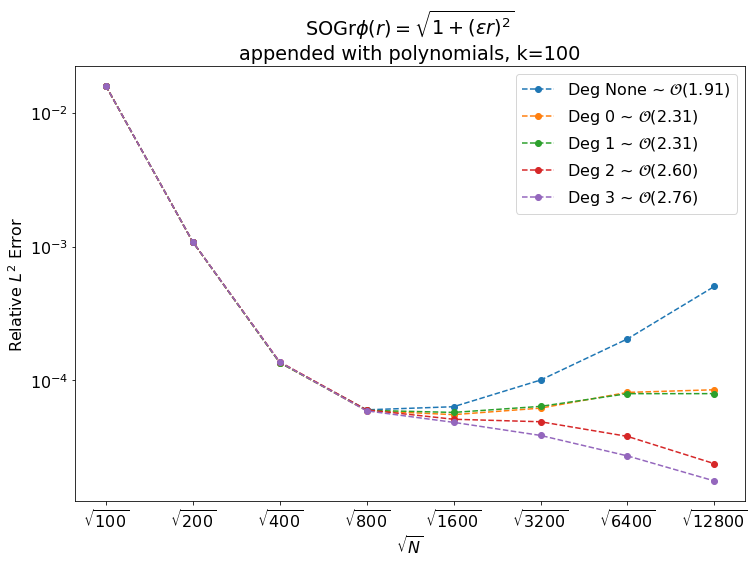

In [24]:
rbf = 'multiquadric'
method = 'SOGr'
poly_type = 'p'
k = 100

# Order calculation terms
o_start = 0
o_end = -1
##################################################
rbf_obj = rbf_dict[rbf]
title = ''
if method is 'SWM':
    title += 'Shankar-Wright Method using '
elif method is 'TPM':
    title += 'Tangent Plane Method using '
elif method is 'SOGr':
    title += 'SOGr'
rbf_obj = rbf_dict[rbf]
title += '$\phi(r)=$' + rbf_obj['tex']
if poly_type is 'p':
    title += '\nappended with polynomials, '
else:
    title += '\nappended with spherical harmonics, '
title += ('k=%d' % k)

my_data = data[(data.method==method) & (data.rbf==rbf) & (data.poly_type==poly_type)]
fig = plt.figure(figsize=(12,8))
legend = []
for i, deg in enumerate(my_data.deg.unique()):
    plot_data = my_data[my_data.deg==str(deg)]
    plt.loglog( np.sqrt(plot_data.N.astype(np.float)), 
               plot_data.rel_L2_error, marker='o', linestyle='dashed')
    order = linreg(np.log(np.sqrt(plot_data.N[o_start:o_end].astype(np.float))), 
               np.log(plot_data.rel_L2_error[o_start:o_end]))[0]
    legend += ['Deg ' + deg + ' ~ $\mathcal{O}(%.2f)$' %(-order)]
    
plt.title(title)
plt.legend( legend )
plt.minorticks_off()
plt.xticks(np.sqrt(ns), ['$\sqrt{%d}$' % n for n in ns])
plt.xlabel('$\sqrt{N}$')
plt.ylabel('Relative $L^2$ Error')
plt.show()

### By Method - (RBF, d, k)

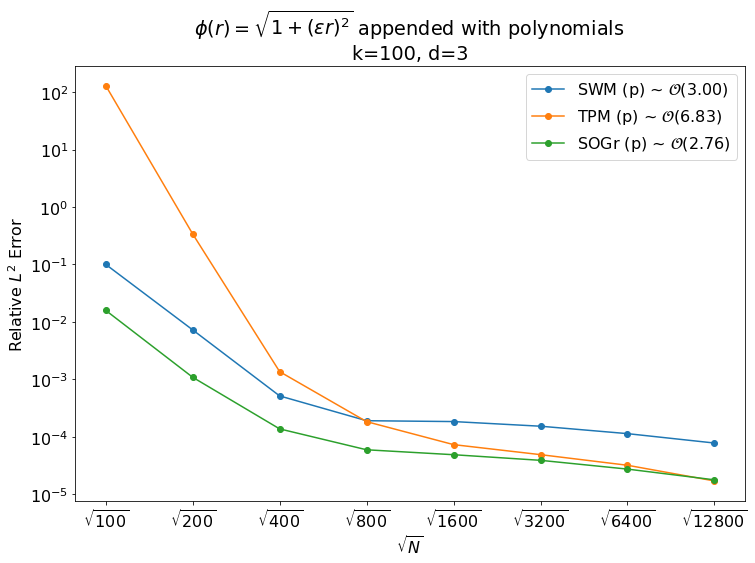

In [25]:
rbf = 'multiquadric'
d = '3'
k = 100

# Order calculation terms
o_start = 0
o_end = -1
##################################################
rbf_obj = rbf_dict[rbf]
title = ''
rbf_obj = rbf_dict[rbf]
title = '$\phi(r)=$' + rbf_obj['tex']
title += ' appended with polynomials \n'
title += ('k=%d, d=%s' % (k, d))

my_data = data[(data.deg==d) & (data.rbf==rbf) & (data.k==k)]
fig = plt.figure(figsize=(12,8))
legend = []
for i, method in enumerate(my_data.method.unique()):
    for poly_type, linestyle, marker in zip('ps', ['-','--'], 'ox'):
        plot_data = my_data[(my_data.method==method) & (my_data.poly_type==poly_type)]
        if len(plot_data)<1: continue
        plt.loglog( np.sqrt(plot_data.N.astype(np.float)), 
                   plot_data.rel_L2_error, marker=marker, linestyle=linestyle)
        order = linreg(np.log(np.sqrt(plot_data.N[o_start:o_end].astype(np.float))), 
                   np.log(plot_data.rel_L2_error[o_start:o_end]))[0]
        legend += [method + ' (' + poly_type +')' + ' ~ $\mathcal{O}(%.2f)$' %(-order)]
    
    
plt.title(title)
plt.legend( legend )
plt.minorticks_off()
plt.xticks(np.sqrt(ns), ['$\sqrt{%d}$' % n for n in ns])
plt.xlabel('$\sqrt{N}$')
plt.ylabel('Relative $L^2$ Error')
plt.show()

### By RBF

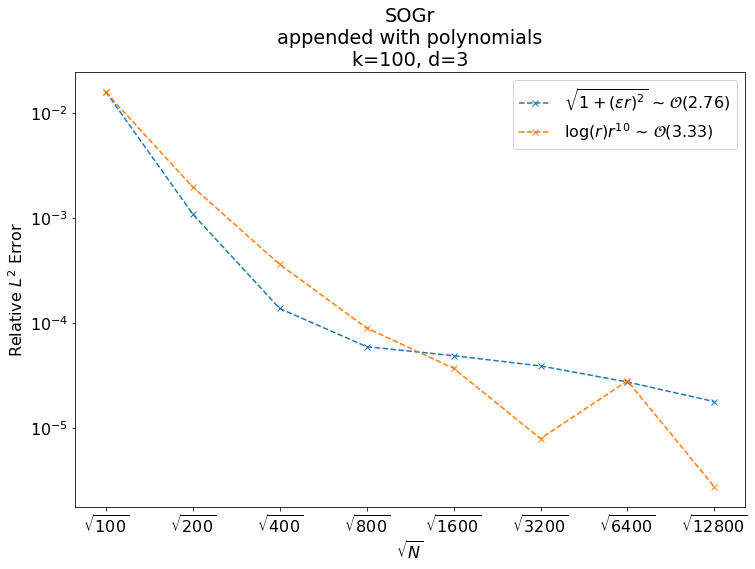

In [26]:
method = 'SOGr'
d = '3'
k = 100
poly_type = 'p'

# Order calculation terms
o_start = 0
o_end = -1
##################################################
title = method + '\n'
rbf_obj = rbf_dict[rbf]
title += ' appended with polynomials \n'
title += ('k=%d, d=%s' % (k, d))

my_data = data[(data.deg==d) & (data.method==method) & (data.k==k) & (data.poly_type==poly_type)]
fig = plt.figure(figsize=(12,8))
legend = []
for i, rbf in enumerate(my_data.rbf.unique()):
    rbf_obj = rbf_dict[rbf]
    plot_data = my_data[(my_data.rbf==rbf)]
    if len(plot_data)<1: continue
    plt.loglog( np.sqrt(plot_data.N.astype(np.float)), 
               plot_data.rel_L2_error, marker=marker, linestyle=linestyle)
    order = linreg(np.log(np.sqrt(plot_data.N[o_start:o_end].astype(np.float))), 
               np.log(plot_data.rel_L2_error[o_start:o_end]))[0]
    legend += [rbf_obj['tex'] + ' ~ $\mathcal{O}(%.2f)$' %(-order)]

    
plt.title(title)
plt.legend( legend )
plt.minorticks_off()
plt.xticks(np.sqrt(ns), ['$\sqrt{%d}$' % n for n in ns])
plt.xlabel('$\sqrt{N}$')
plt.ylabel('Relative $L^2$ Error')
plt.show()

### By Stencil Size

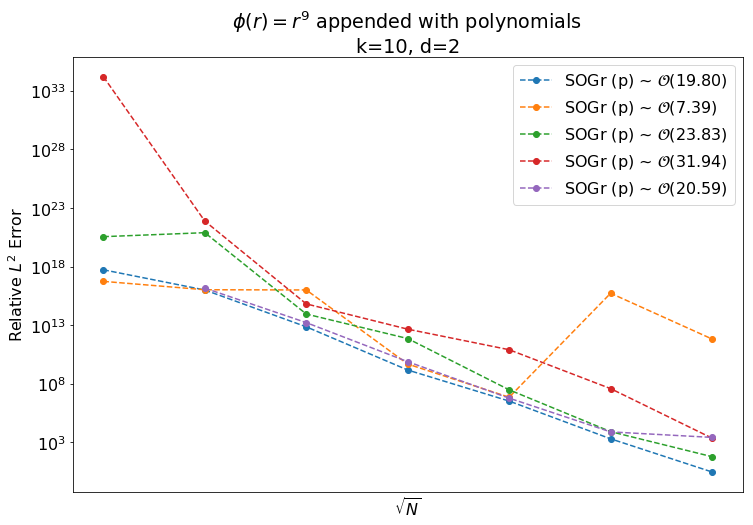

In [24]:
method = 'SOGr'
rbf = 'r^9'
d = '2'

# Order calculation terms
o_start = 0
o_end = -1
##################################################
rbf_obj = rbf_dict[rbf]
title = ''
rbf_obj = rbf_dict[rbf]
title = '$\phi(r)=$' + rbf_obj['tex']
title += ' appended with polynomials \n'
title += ('k=%d, d=%s' % (k, d))

my_data = data[(data.rbf==rbf) & (data.method==method)]
fig = plt.figure(figsize=(12,8))
legend = []
for deg in my_data.deg.unique():
    plot_data = my_data[(my_data.deg==deg)]
    if len(plot_data)<1: continue
    plt.loglog( np.sqrt(plot_data.k.astype(np.float)), 
               plot_data.rel_L2_error, 'o--')
    order = linreg(np.log(np.sqrt(plot_data.k[o_start:o_end].astype(np.float))), 
               np.log(plot_data.rel_L2_error[o_start:o_end]))[0]
    legend += [method + ' (' + poly_type +')' + ' ~ $\mathcal{O}(%.2f)$' %(-order)]
    
    
plt.title(title)
plt.legend( legend )
plt.minorticks_off()
plt.xticks(np.sqrt(ns), ['$\sqrt{%d}$' % n for n in ns])
plt.xlabel('$\sqrt{N}$')
plt.ylabel('Relative $L^2$ Error')
plt.show()

In [19]:
display(plot_data)

,surface,nodeset,N,k,method,rbf,epsilon,poly_type,deg,rel_L2_error,max_error,Re_eig
12,S,spiral,800,10,SOGr,multiquadric,None,p,2,0.018075,0.015248,2.842171e-14


### Mixing Methods and Rbfs

,surface,nodeset,N,k,method,rbf,epsilon,poly_type,deg,rel_L2_error,max_error,Re_eig
0,S,spiral,1600,50,SWM,multiquadric,None,p,None,0.000261,0.000181,-5.034726e-05
1,S,spiral,1600,50,SWM,multiquadric,None,p,0,0.000231,0.000185,3.605425e-13
2,S,spiral,1600,50,SWM,multiquadric,None,p,1,0.000237,0.000196,1.023626e-12
3,S,spiral,1600,50,SWM,multiquadric,None,p,2,0.000234,0.000186,1.217385e-14
4,S,spiral,1600,50,SWM,multiquadric,None,p,3,0.000215,0.000192,-1.707361e-12
5,S,spiral,1600,50,SWM,multiquadric,None,p,4,0.000158,0.000139,-1.481110e-11
6,S,spiral,1600,50,TPM,multiquadric,None,p,None,0.000126,0.000103,-3.412607e-05
7,S,spiral,1600,50,TPM,multiquadric,None,p,0,0.000120,0.000114,-9.221965e-14
8,S,spiral,1600,50,TPM,multiquadric,None,p,1,0.000120,0.000110,-1.412688e-14
9,S,spiral,1600,50,TPM,multiquadric,None,p,2,0.000112,0.000091,-3.736313e-15


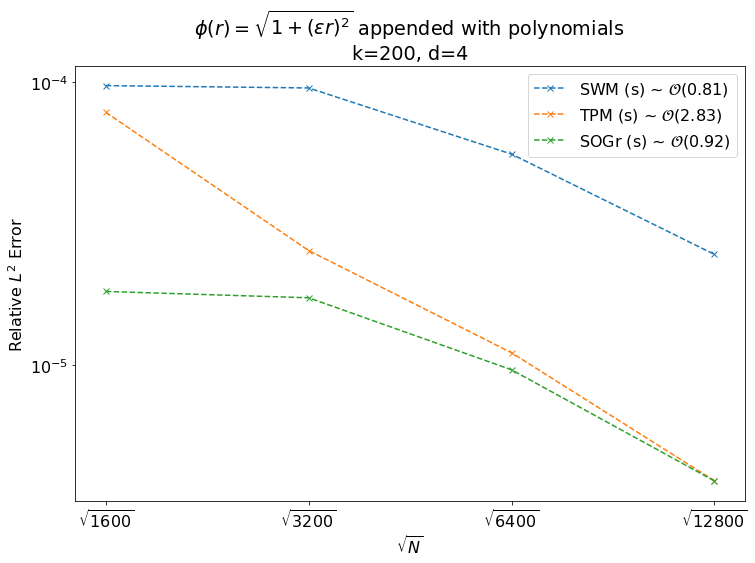

In [57]:
rbf = 'multiquadric'
d = '4'
k = 200

# Order calculation terms
o_start = 0
o_end = -1
##################################################
rbf_obj = rbf_dict[rbf]
title = ''
rbf_obj = rbf_dict[rbf]
title = '$\phi(r)=$' + rbf_obj['tex']
title += ' appended with polynomials \n'
title += ('k=%d, d=%s' % (k, d))

my_data = data[(data.deg==d) & (data.k==k)]
display(data)
fig = plt.figure(figsize=(12,8))
legend = []
for method in my_data.method.unique():
    for rbf in my_data.rbf.unique():
        plot_data = my_data[(my_data.method==method) & (my_data.rbf==rbf)]
        if len(plot_data)<1: continue
        plt.loglog( np.sqrt(plot_data.N.astype(np.float)), 
                   plot_data.rel_L2_error, marker=marker, linestyle=linestyle)
        order = linreg(np.log(np.sqrt(plot_data.N[o_start:o_end].astype(np.float))), 
                   np.log(plot_data.rel_L2_error[o_start:o_end]))[0]
        legend += [method + ' (' + poly_type +')' + ' ~ $\mathcal{O}(%.2f)$' %(-order)]
    
    
plt.title(title)
plt.legend( legend )
plt.minorticks_off()
plt.xticks(np.sqrt(ns), ['$\sqrt{%d}$' % n for n in ns])
plt.xlabel('$\sqrt{N}$')
plt.ylabel('Relative $L^2$ Error')
plt.show()

In [54]:
display(my_data)

,surface,nodeset,N,k,method,rbf,epsilon,poly_type,deg,rel_L2_error,max_error,Re_eig
23,S,spiral,1600,200,SWM,multiquadric,None,p,4,0.000097,0.000083,-5.056425e-12
29,S,spiral,1600,200,TPM,multiquadric,None,p,4,0.000078,0.000073,-1.785964e-14
35,S,spiral,1600,200,SOGr,multiquadric,None,p,4,0.000018,0.000016,-3.739238e-13
59,S,spiral,3200,200,SWM,multiquadric,None,p,4,0.000096,0.000091,-4.036219e-13
65,S,spiral,3200,200,TPM,multiquadric,None,p,4,0.000025,0.000022,-4.312587e-15
71,S,spiral,3200,200,SOGr,multiquadric,None,p,4,0.000017,0.000020,-6.655170e-13
95,S,spiral,6400,200,SWM,multiquadric,None,p,4,0.000056,0.000099,5.604881e-12
101,S,spiral,6400,200,TPM,multiquadric,None,p,4,0.000011,0.000011,2.392240e-13
107,S,spiral,6400,200,SOGr,multiquadric,None,p,4,0.000010,0.000015,-2.096101e-13
130,S,spiral,12800,200,SWM,multiquadric,None,p,4,0.000025,0.000033,-1.063363e-10


# Eigenvalue Plots

In [35]:
param = 'rbf'

methods = ['SWM', 'TPM', 'SOGr']
poly_degs = [None, 0, 1, 3, 4]
# rbf_labels = ['r^8 log(r)', 'r^12 log(r)', 'r^14 log(r)']
rbf_labels = ['r^9', 'r^11', 'r^13', 'r^15']
ks = [10*2**i for i in range(1,5)]

# Defaults

method = 'SOGr'
surface = 'S'
node_set = 'spiral'
n = 100
k = 100
rbf_obj = rbf_dict['gaussian']
epsilon = None
poly_type = 'p'
poly_deg = 4

######################################################

n, nodes = gen_sphere_nodes(node_set, n)
normals = nodes
Cs = []
legend = []

if param is 'deg':
    title = 'Eigenvalues for n=%d, k=%d\n' % (n, k)
    if method is 'SWM':
        title += 'Shankar-Wright Method, '
    elif method is 'TPM':
        title += 'Tangent Plane Method, '
    title += '$\phi(r)=$' + rbf_obj['tex']
    for poly_deg in poly_degs:
        C = get_weights(method, surface, node_set, n, k, nodes, normals, rbf_obj, epsilon, poly_type, poly_deg)
        Cs += [C]
        legend += ['deg = ' + str(poly_deg)]
        
elif param is 'method':
    title = 'Eigenvalues for n=%d, k=%d, d=%s\n' % (n, k, str(poly_deg))
    title += '$\phi(r)=$' + rbf_obj['tex']
    for method in methods:
        C = get_weights(method, surface, node_set, n, k, nodes, normals, rbf_obj, epsilon, poly_type, poly_deg)
        Cs += [C]
        legend += [method]

elif param is 'rbf':
    title = 'Eigenvalues for n=%d, k=%d, d=%s\n' % (n, k, str(poly_deg))
    if method is 'SWM':
        title += 'Shankar-Wright Method'
    elif method is 'TPM':
        title += 'Tangent Plane Method'
    for rbf_label in rbf_labels:
        rbf_obj = rbf_dict[rbf_label]
        C = get_weights(method, surface, node_set, n, k, nodes, normals, rbf_obj, epsilon, poly_type, poly_deg)
        Cs += [C]
        legend += [rbf_obj['tex']]
        
elif param is 'k':
    title = 'Eigenvalues for n=%d, d=%s\n' % (n, str(poly_deg))
    if method is 'SWM':
        title += 'Shankar-Wright Method, '
    elif method is 'TPM':
        title += 'Tangent Plane Method, '
    title += '$\phi(r)=$' + rbf_obj['tex']
    for k in ks:
        C = get_weights(method, surface, node_set, n, k, nodes, normals, rbf_obj, epsilon, poly_type, poly_deg)
        Cs += [C]
        legend += ['k = ' + str(k)]

In [36]:
for C1, C2 in itertools.combinations(Cs, r=2):
    print(np.max(np.abs(C1-C2)))
eigs = [la.eig(C.todense())[0] for C in Cs]

444958488.5654345
443093597.71581453
444509077.8561418
77854956.25757904
78927862.64690202
74060563.8163281


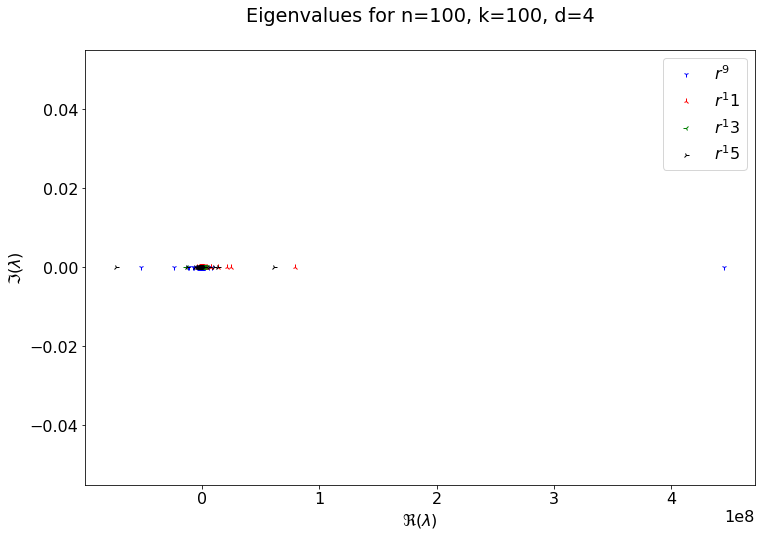

In [37]:
styles = ['b1', 'r2', 'g3', 'k4', 'yx', 'm^', 'cv']
fig = plt.figure(figsize=(12,8))
for eig, style in zip(eigs, styles):
    plt.plot(eig.real, eig.imag, style)
    
plt.legend(legend)
    
plt.title(title)
# plt.minorticks_off()
plt.xlabel('$\Re(\lambda)$')
plt.ylabel('$\Im(\lambda)$')
plt.show()

# Saved Runs